In [167]:
%matplotlib inline
import math
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn import model_selection, ensemble
from sklearn.metrics import accuracy_score, log_loss
import xgboost as xgb



In [276]:
# функция на работу с уже полученными вероятностями
# пока не в деле, но я думаю, что их хитрым образом можно как-то потрогать и улучшить логлосс
def expand(array, k=0):
    k = np.array(k).reshape((-1, 1))
    new = (array - 0.5) * (1 + k) + 0.5
    return [i for i in new]

In [512]:
# класс с нашими моделями
# сразу при вызове забирает данные из глобальных x_test, t_train и y_train
# учитывает только колонки из листа params (локальный, обязательный)
# бьет их на части из листа split (локальный, необязательный)
# сразу все фитует и даже считает y_test

class ML():
    model = None
    errors = None
    log_loss = None
    data = []
    
    
    def __init__(self, model, params, split=None):
        self.params = params
        self.model = model
        self.split = split
        self.form()
        self.fit()

    
    def form(self):
        from operator import and_
        from functools import reduce
        
        # над этими строчками я так потел, что пахнуть должно до сих пор
        # говнокод, впрочем, вышел знатный
        
        if self.split:
            x_y_train_feed = pd.concat([x_train, pd.DataFrame(y_train, columns=["returned"])], axis=1)
            for i in range(2**len(self.split)):
                a = reduce(and_, 
                           [x_y_train_feed[self.split[j]] == bool(i & (2**j)) for j in range(len(self.split))])
                b = reduce(and_, 
                           [x_test[self.split[j]] == bool(i & (2**j)) for j in range(len(self.split))])
                self.data.append({"x_train": x_y_train_feed[a][self.params],
                                  "y_train": list(x_y_train_feed[a].returned),
                                  "x_test": x_test[b][self.params]})
        else:
            self.data = [{"x_train": x_train[self.params],
                          "y_train": list(y_train.returned),
                          "x_test": x_test[self.params]}]
    
    def fit(self):
        y1v, y2v, y1p, y2p, y1r, y2r = [], [], [], [], [], []
        out, xtr = [], []
        for dataset in self.data:
            x1, x2, y1, y2 = train_test_split(dataset["x_train"], dataset["y_train"], 
                                                              test_size = 0.3, random_state=42)
            xt = dataset["x_test"]
            
            self.model.fit(x1, y1)
            
            # values
            y1v.append(self.model.predict(x1))
            y2v.append(self.model.predict(x2))
            # probabilities
            y1p.append(self.model.predict_proba(x1))
            y2p.append(self.model.predict_proba(x2))
            # true values
            y1r.append(np.array(y1))
            y2r.append(np.array(y2))
            #
            out.append(self.model.predict_proba(xt))
            xtr.append(xt)
        
        y1v = np.concatenate(y1v)
        y2v = np.concatenate(y2v)
        y1p = np.concatenate(y1p)
        y2p = np.concatenate(y2p)
        y1r = np.concatenate(y1r)
        y2r = np.concatenate(y2r)
        
        out = np.concatenate(out)
        #pprint(xtr)
        #pprint(out)
        #pprint(y1r)
        self.errors = np.mean(y1r != y1v), np.mean(y2r != y2v)
        self.log_loss = log_loss(y1r, y1p, eps=1e-15), log_loss(y2r, y2p, eps=1e-15)
                              
        importances = self.model.feature_importances_
    
    def dump(self, data):
        a = self.model.predict_proba(data)
        np.savetxt("data/y_test.csv", a[:,1], fmt='%10.5f')

#GB = ML(ensemble.GradientBoostingClassifier(n_estimators=100, random_state=42), 
#        params, 
#        split=["zeroTotalScore"])

In [91]:
xytte = pd.read_csv("data/xytte.csv")

####################### ВНИМАНИЕ #######################
# здесь трейн это которые в задаче трейн, с ответами
# тест без ответов
# но дальше в алгоритмах трейн будет разбиваться на два подсета
# которые будут у меня называться x1-y1 и x2-y2, а по смыслу как раз трейн и тест
# надо не перепутать

x_train = xytte[xytte.returned == xytte.returned].reset_index(drop=True).drop("returned", axis=1)
y_train = xytte[xytte.returned == xytte.returned].reset_index(drop=True)[["returned"]]
x_test  = xytte[xytte.returned != xytte.returned].reset_index(drop=True).drop("returned", axis=1)

In [92]:
# проверяем, что нигде не налажали
# читаем из файла оригинальные данные

x_test_ref = pd.read_csv("data/x_test.csv", sep=";", dtype=np.float32)
x_train_ref = pd.read_csv("data/x_train.csv", sep=";", dtype=np.float32)
y_train_ref = pd.read_csv("data/y_train.csv", sep=";", dtype=np.float32, header=None, names=["returned"])

# заводим функцию на сравнение таблиц

def df_equal(df1, df2):
    if list(df1.columns) != list(df2.columns): 
        print("Mismatch columns:")
        print("df1: ", list(df1.columns))
        print("df2: ", list(df2.columns))
        return False
    if list(df1.index) != list(df2.index): 
        print("Mismatch index:")
        print("df1: ", list(df1.columns)[0], ":", list(df1.columns)[-1])
        print("df2: ", list(df2.columns)[0], ":", list(df2.columns)[-1])
        return False
    
    ne_stacked = (df1 != df2).stack()
    changed = ne_stacked[ne_stacked]
    changed.index.names = ['id', 'col']

    difference_locations = np.where(df1 != df2)
    changed_from = df1.values[difference_locations]
    changed_to = df2.values[difference_locations]
    diff = pd.DataFrame({'from': changed_from, 'to': changed_to}, index=changed.index)
    return not diff[diff["from"] - diff["to"] > 0.000001].count()[0]

# ассертим наши таблицы

assert(df_equal(x_test[x_test_ref.columns], x_test_ref))
assert(df_equal(x_train[x_train_ref.columns], x_train_ref))
assert(df_equal(y_train, y_train_ref))

In [332]:
params_all = list(x_train.columns)

params_orig = [
'maxPlayerLevel',
'numberOfAttemptedLevels',
'attemptsOnTheHighestLevel',
'totalNumOfAttempts',
'averageNumOfTurnsPerCompletedLevel',
'numberOfBoostersUsed',
'fractionOfUsefullBoosters',
'totalScore',
'totalBonusScore',
'totalStarsCount',
'numberOfDaysActuallyPlayed',
]
     
params_mod = [
#'attemptsOnTheHighestLevel_dvd',
'attemptsOnTheHighestLevel_ln',
'attemptsPerDay',
'averageNumOfTurnsPerCompletedLevel_dvd',
'maxPlayerLevel_ln',
'numberOfAttemptedLevels_dvd',
#'numberOfBoostersUsed_dvd',
'numberOfBoostersUsed_dvd_ln',
#'numberOfBoostersUsed_ln',
'numberOfDaysActuallyPlayed_ln',
'totalBonusScore_dvd',
'totalNumOfAttempts_ln',
#'totalScore_ln',
'totalScore_ln_dvd',
#'totalStarsCount_dvd',
'totalStarsCount_dvd_ln',
#'totalStarsCount_ln',
]

params_bool = [
'allAttemptsOnTheHighestLevel',
'attLevelsMoreThanMaxLevel',
'doReturnOnLowerLevels',
'zeroTotalScore',
'zeroTurnsPerCompletedLevel'
]

params_orig_norm = [
'attemptsOnTheHighestLevel_norm',
'attemptsPerDay_norm',
#'numberOfBoostersUsed_norm',
#'maxPlayerLevel_norm',
'fractionOfUsefullBoosters_norm',
#'averageNumOfTurnsPerCompletedLevel_norm',
'numberOfDaysActuallyPlayed_norm',
'totalNumOfAttempts_norm',
'totalBonusScore_norm',
'totalScore_norm',
'totalStarsCount_norm',
]

params_mod_norm = [
'attemptsOnTheHighestLevel_dvd_norm',
#'attemptsOnTheHighestLevel_ln_norm',
'averageNumOfTurnsPerCompletedLevel_dvd_norm',
'maxPlayerLevel_ln_norm',
'numberOfAttemptedLevels_dvd_norm',
#'numberOfAttemptedLevels_norm',
'numberOfBoostersUsed_dvd_ln_norm',
#'numberOfBoostersUsed_dvd_norm',
#'numberOfBoostersUsed_ln_norm',
'numberOfDaysActuallyPlayed_ln_norm',
'totalBonusScore_dvd_norm',
'totalNumOfAttempts_ln_norm',
'totalScore_ln_dvd_norm',
#'totalScore_ln_norm',
'totalStarsCount_dvd_ln_norm',
#'totalStarsCount_dvd_norm',
'totalStarsCount_ln_norm',
]

params_rf_sorted = [
'numberOfDaysActuallyPlayed_ln',
'totalNumOfAttempts',
'totalBonusScore_dvd_norm',
'averageNumOfTurnsPerCompletedLevel',
'totalScore_ln_dvd',
'averageNumOfTurnsPerCompletedLevel_dvd',
'maxPlayerLevel_ln_norm',
'attemptsOnTheHighestLevel_dvd_norm',
'totalStarsCount_dvd_norm',
'attemptsPerDay_norm',
'numberOfBoostersUsed_dvd_norm',
'fractionOfUsefullBoosters_norm',
'numberOfAttemptedLevels_dvd_norm',
'doReturnOnLowerLevels',
'attLevelsMoreThanMaxLevel',
'allAttemptsOnTheHighestLevel',
'zeroTotalScore',
'zeroTurnsPerCompletedLevel'
]

In [333]:
#params = params_orig + ["doReturnOnLowerLevels"]
#params = params_mod_norm + params_bool
#params = params_bool
#params = params_bool + params_orig
#params = params_all
params = params_rf_sorted
#params

In [335]:
x_train_feed = x_train[params]
x_test_feed = x_test[params]
y_train_feed = list(y_train.returned)
#y_test_feed = list(y_test)

x1, x2, y1, y2 = train_test_split(x_train_feed, y_train_feed, test_size = 0.3, random_state=42)

assert(set(list(x_train_feed.columns)) == set(list(x_test_feed.columns)))
assert(set(list(x1.columns)) == set(list(x2.columns)))
assert(type(y1) == list)
assert(type(y2) == list)
assert(len(y1) == len(x1.index))
assert(len(y2) == len(x2.index))

#list(x1.columns), list(x2.columns) 

In [503]:
RF = ML(ensemble.RandomForestClassifier(n_estimators=600, max_features=10, random_state=42),
        params,
        split=None)

In [504]:
print(RF.log_loss)

(0.11290972152633583, 0.46088576846588436)


In [513]:
GB = ML(ensemble.GradientBoostingClassifier(n_estimators=100, random_state=42), 
        params, 
        split=["zeroTotalScore"])

In [514]:
print(GB.log_loss)

(0.36354558301309009, 0.38184434588807786)


In [508]:
XGB = ML(xgb.XGBClassifier(),
        params,
        split=["zeroTotalScore"])

In [509]:
print(XGB.log_loss)


(0.36585039983917783, 0.38018562523907151)


In [326]:
a = XGB.dump(x_test_feed)

In [342]:
importances = RF.model.feature_importances_
indices = np.argsort(importances)[::-1]
a, b = [], []
for f, idx in enumerate(indices):
    print("{:2d}. feature '{:5s}' ({:.4f})".format(f + 1, params[idx], importances[idx]))
    a.append(params[idx])
    b.append(importances[idx])

 1. feature 'numberOfDaysActuallyPlayed_ln' (0.2353)
 2. feature 'totalNumOfAttempts' (0.1509)
 3. feature 'maxPlayerLevel_ln_norm' (0.0767)
 4. feature 'totalBonusScore_dvd_norm' (0.0745)
 5. feature 'totalScore_ln_dvd' (0.0713)
 6. feature 'averageNumOfTurnsPerCompletedLevel' (0.0690)
 7. feature 'totalStarsCount_dvd_norm' (0.0643)
 8. feature 'averageNumOfTurnsPerCompletedLevel_dvd' (0.0551)
 9. feature 'numberOfBoostersUsed_dvd_norm' (0.0538)
10. feature 'attemptsOnTheHighestLevel_dvd_norm' (0.0511)
11. feature 'attemptsPerDay_norm' (0.0424)
12. feature 'fractionOfUsefullBoosters_norm' (0.0313)
13. feature 'numberOfAttemptedLevels_dvd_norm' (0.0176)
14. feature 'doReturnOnLowerLevels' (0.0052)
15. feature 'attLevelsMoreThanMaxLevel' (0.0011)
16. feature 'allAttemptsOnTheHighestLevel' (0.0002)
17. feature 'zeroTotalScore' (0.0001)
18. feature 'zeroTurnsPerCompletedLevel' (0.0001)


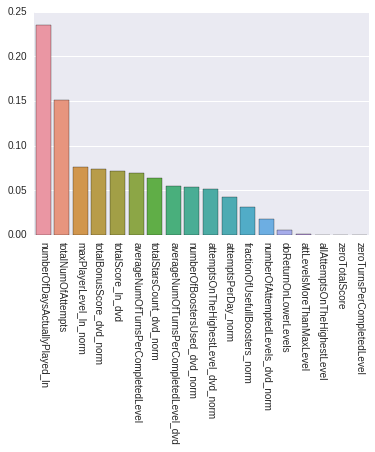

In [350]:
b_log = (-np.log10(b) * 100).astype(int)
#len(b_log)
g = sns.barplot(x=a, y=b)
for item in g.get_xticklabels():
    item.set_rotation(270)
#plt.bar(len(b_log), list(b_log))
#plt.xticks(len(a), a, rotation='vertical')